In [1]:
from __future__ import print_function, division
import argparse
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import os, shutil
import math
import fnmatch
from collections import OrderedDict
import cv2

import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import time
import copy
import seaborn as sns
from pytorch_model_summary import summary
from torch.nn.utils import weight_norm
from matplotlib import pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1
cuda:0
NVIDIA GeForce RTX 3080 Ti


In [2]:
class CAE_Fused(nn.Module):
    def __init__(self, input_shape=[80,80,80,1], input_shape_tm=[400,400,1], latent_channels=512, filters=[32, 64, 128, 256]):
        super(CAE_Fused, self).__init__()
        self.pretrained = False
        self.latent_channels = latent_channels
        self.input_shape = input_shape
        self.input_shape_tm = input_shape_tm
        self.filters = filters
        
        self.encoder3d = nn.Sequential(OrderedDict([
            ('conv3d1_1', weight_norm(nn.Conv3d(input_shape[3], filters[0]//2, 3, padding=1))),
          ('relu3d1_1', nn.ReLU()),
          ('maxpool3d1_1', nn.MaxPool3d(2)),
          ('bn3d1_1', nn.BatchNorm3d(filters[0]//2)),
            ('conv3d2_1', weight_norm(nn.Conv3d(filters[0]//2, filters[1]//2, 3, padding=1))),
          ('relu3d2_1', nn.ReLU()),
          ('maxpool3d2_1', nn.MaxPool3d(2)),
          ('bn3d2_1', nn.BatchNorm3d(filters[1]//2)),
            ('conv3d3_1', weight_norm(nn.Conv3d(filters[1]//2, filters[2]//2, 3, padding=1))),
          ('relu3d3_1', nn.ReLU()),
          ('maxpool3d3_1', nn.MaxPool3d(2)),
          ('bn3d3_1', nn.BatchNorm3d(filters[2]//2)),
            ('conv3d4_1', weight_norm(nn.Conv3d(filters[2]//2, filters[3]//2, 3, padding=1))),
          ('relu3d4_1', nn.ReLU()),
          ('maxpool3d4_1', nn.MaxPool3d(2))
        ]))
        lin_features_len_3d = (filters[3]//2)*(input_shape[0]//2//2//2//2)*(input_shape[1]//2//2//2//2)*(input_shape[2]//2//2//2//2)
        self.embedding3d = nn.Linear(lin_features_len_3d, latent_channels)
        self.deembedding3d = nn.Linear(latent_channels, lin_features_len_3d)
        self.relu = nn.ReLU()
        
        self.decoder3d = nn.Sequential(OrderedDict([
            ('upsample3d1_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('upsample3d2_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d1_2', weight_norm(nn.Conv3d(filters[3]//2, filters[2]//2, 3, padding=1))),
          ('relu3d1_2', nn.ReLU()),
          ('bn3d1_2', nn.BatchNorm3d(filters[2]//2)),
            ('upsample3d3_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d2_2', weight_norm(nn.Conv3d(filters[2]//2, filters[1]//2, 3, padding=1))),
          ('relu3d2_2', nn.ReLU()),
          ('bn3d2_2', nn.BatchNorm3d(filters[1]//2)),
            ('upsample3d4_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d3_2', weight_norm(nn.Conv3d(filters[1]//2, filters[0]//2, 3, padding=1))),
          ('relu3d3_2', nn.ReLU()),
          ('bn3d3_2', nn.BatchNorm3d(filters[0]//2)),
            ('conv3d4_2', nn.Conv3d(filters[0]//2, input_shape[3], 1)),
          ('relu3d4_2', nn.ReLU())
        ]))
        
        self.encoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_1', nn.Conv2d(input_shape_tm[2], filters[0], 5, stride=2, padding=2, bias=False)),
          ('relu2d1_1', nn.ReLU()),
          ('bn2d1_1', nn.BatchNorm2d(filters[0])),
            ('conv2d2_1', nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=False)),
          ('relu2d2_1', nn.ReLU()),
          ('bn2d2_1', nn.BatchNorm2d(filters[1])),
            ('conv2d3_1', nn.Conv2d(filters[1], filters[2], 5, stride=2, padding=2, bias=False)),
          ('relu2d3_1', nn.ReLU()),
          ('bn2d3_1', nn.BatchNorm2d(filters[2])),
            ('conv2d4_1', nn.Conv2d(filters[2], filters[3], 3, stride=2, padding=0, bias=False)),
          ('relu2d4_1', nn.ReLU()),
        ]))
        lin_features_len = ((input_shape_tm[0] // 2 // 2 // 2 - 1) // 2) * ((input_shape_tm[1] // 2 // 2 // 2 - 1) // 2) * \
                           filters[3]
        self.embedding2d = nn.Linear(lin_features_len, latent_channels, bias=False)
        self.deembedding2d = nn.Linear(latent_channels, lin_features_len, bias=False)
        
        out_pad1 = 1 if input_shape_tm[0] // 2 // 2 // 2 % 2 == 0 else 0
        out_pad2 = 1 if input_shape_tm[0] // 2 // 2 % 2 == 0 else 0
        out_pad3 = 1 if input_shape_tm[0] // 2 % 2 == 0 else 0
        out_pad4 = 1 if input_shape_tm[0] % 2 == 0 else 0
        self.decoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_2', nn.ConvTranspose2d(filters[3], filters[2], 3, stride=2, padding=0, output_padding=out_pad1, bias=False)),
          ('relu2d1_2', nn.ReLU()),
          ('bn2d1_2', nn.BatchNorm2d(filters[2])),
            ('conv2d2_2', nn.ConvTranspose2d(filters[2], filters[1], 5, stride=2, padding=2, output_padding=out_pad2, bias=False)),
          ('relu2d2_2', nn.ReLU()),
          ('bn2d2_2', nn.BatchNorm2d(filters[1])),
            ('conv2d3_2', nn.ConvTranspose2d(filters[1], filters[0], 5, stride=2, padding=2, output_padding=out_pad3, bias=False)),
          ('relu2d3_2', nn.ReLU()),
          ('bn2d3_2', nn.BatchNorm2d(filters[0])),
            ('conv2d4_2', nn.ConvTranspose2d(filters[0], input_shape_tm[2], 5, stride=2, padding=2, output_padding=out_pad4, bias=False)),
          ('relu2d4_2', nn.ReLU())
        ]))

    def forward(self, x_input):
        x1, x = x_input
        
        # tansmission
        x = self.encoder2d(x)
        x = x.view(x.size(0), -1)
        x = self.embedding2d(x)
        x_out = x
        
        x = self.deembedding2d(x)
        x = self.relu(x)
        x = x.view(x.size(0), self.filters[3], ((self.input_shape_tm[0]//2//2//2-1) // 2), ((self.input_shape_tm[1]//2//2//2-1) // 2))
        
        x = self.decoder2d(x)
            
            
        # SSC
        x1 = self.encoder3d(x1)
        x1 = x1.view(x1.size(0),-1)
        x1 = self.embedding3d(x1)
        
        x1_out = x1
        
        x1 = self.deembedding3d(x1)
        x1 = self.relu(x1)
        x1 = x1.view(x1.size(0), self.filters[3]//2, self.input_shape[0]//2//2//2//2, self.input_shape[1]//2//2//2//2, self.input_shape[2]//2//2//2//2) # 128 5^3
        
        x1 = self.decoder3d(x1)
        
        extra_out = (x_out, x1_out)
        
        return (x1, x), extra_out 

In [3]:
class CAE_2d_classify(nn.Module):
    def __init__(self, input_shape=[400,400,1], latent_channels=512, num_clusters=2, filters=[32, 64, 128, 256], dropout=0.1):
        super(CAE_2d_classify, self).__init__()
        self.pretrained = False
        self.latent_channels = latent_channels
        self.input_shape = input_shape
        self.filters = filters
        self.num_clusters = num_clusters
        
        self.encoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_1', nn.Conv2d(input_shape[2], filters[0], 5, stride=2, padding=2, bias=False)),
          ('relu2d1_1', nn.ReLU()),
          ('bn2d1_1', nn.BatchNorm2d(filters[0])),
            ('conv2d2_1', nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=False)),
          ('relu2d2_1', nn.ReLU()),
          ('bn2d2_1', nn.BatchNorm2d(filters[1])),
            ('conv2d3_1', nn.Conv2d(filters[1], filters[2], 5, stride=2, padding=2, bias=False)),
          ('relu2d3_1', nn.ReLU()),
          ('bn2d3_1', nn.BatchNorm2d(filters[2])),
            ('conv2d4_1', nn.Conv2d(filters[2], filters[3], 3, stride=2, padding=0, bias=False)),
          ('relu2d4_1', nn.ReLU()),
        ]))
        lin_features_len = ((input_shape[0] // 2 // 2 // 2 - 1) // 2) * ((input_shape[1] // 2 // 2 // 2 - 1) // 2) * \
                           filters[3]
        self.embedding2d = nn.Linear(lin_features_len, latent_channels, bias=False)
        self.fc1 = nn.Linear(latent_channels, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, num_clusters)
        self.relu = nn.ReLU()

    def forward(self, x):
        # tansmission
        x = self.encoder2d(x)
        x = x.view(x.size(0), -1)
        x = self.embedding2d(x)
        x_out = x
        
        x = x
        x = self.relu(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        
        pred = nn.functional.log_softmax(x,dim=1)
        
        return pred

In [4]:
print(summary(CAE_2d_classify(latent_channels=512),torch.zeros((1,1,400,400)), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 200, 200]             800             800
            ReLU-2     [1, 32, 200, 200]               0               0
     BatchNorm2d-3     [1, 32, 200, 200]              64              64
          Conv2d-4     [1, 64, 100, 100]          51,200          51,200
            ReLU-5     [1, 64, 100, 100]               0               0
     BatchNorm2d-6     [1, 64, 100, 100]             128             128
          Conv2d-7      [1, 128, 50, 50]         204,800         204,800
            ReLU-8      [1, 128, 50, 50]               0               0
     BatchNorm2d-9      [1, 128, 50, 50]             256             256
         Conv2d-10      [1, 256, 24, 24]         294,912         294,912
           ReLU-11      [1, 256, 24, 24]               0               0
         Linear-12              [1, 512]      75,4

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
#     print(output.size())
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_checkpoint(state, is_best_loss, filename='checkpoint.pth.tar', dirname='.'):
    fpath = os.path.join(dirname, filename + '_latest.pth.tar')
    torch.save(state, fpath)
    if is_best_loss:
        bpath = os.path.join(dirname, filename + '_best_acc.pth.tar')
        shutil.copyfile(fpath, bpath)
        
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          my_dpi=100,
                          title=None,
                          saved=True,
                          save_name='Unsupervised Learning.png'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=my_dpi)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if saved:
        plt.savefig(save_name, dpi=my_dpi*10, bbox_inches='tight')

In [6]:
def training(model, dataloaders, criterion, optimizers, schedulers, params):
    # Note the time
    since = time.time()

    best_val_acc = 0
    losses_tr = []
    losses_val = []
    learning_rate = []
    accs_tr = []
    accs_val = []

    # Unpack parameters
    pretrained = params['model_files']
    print_freq = params['print_freq']
    dataset_size = params['dataset_size']
    device = params['device']
    batch = params['batch']
    num_epochs = params['epochs']
    fused = params['fused']

    # Prep variables for weights and accuracy of the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # optionally resume from a checkpoint
    if params['resume']:
        if os.path.isfile(params['resume']):
            print("=> loading checkpoint '{}'".format(params['resume']))
            checkpoint = torch.load(params['resume'])
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']

            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(params['resume']))
            
    ckpt_dir = params['ckpt_dir']
    
    optimizer1, optimizer2 = optimizers
    scheduler1, scheduler2 = schedulers
    dataloader_train, dataloader_val = dataloaders
    
    # Go through all epochs
    print('\nPretraining')
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('\n\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        if epoch < 5:
            for param_group in optimizer1.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        else:
            for param_group in optimizer2.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        if fused:
            loss_tr, acc_tr = train_fused(dataloader_train, model, criterion, optimizers, params, epoch)
            loss_val, acc_val = validate_fused(dataloader_val, model, criterion, params, epoch)
        else:
            loss_tr, acc_tr = train_fused(dataloader_train, model, criterion, optimizers, params, epoch)
            loss_val, acc_val = validate_fused(dataloader_val, model, criterion, params, epoch)
#             raise('Not Implemented!')
        
        # learning scheduler
        if epoch < 5:
            scheduler1.step(loss_val)
        elif epoch > num_epochs * (1/3):
            scheduler2.step(loss_val)
            
        # append values
        losses_tr.append(loss_tr)
        losses_val.append(loss_val)
        accs_tr.append(acc_tr)
        accs_val.append(acc_val)
        learning_rate.append(lr)
        
        is_best_acc = acc_val > best_val_acc
        if is_best_acc:
            best_val_acc = max(acc_val, best_val_acc)
            print('Best val acc reached at epoch: {:.0f}\t Accuracy: {:.3f}'.format(epoch+1, best_val_acc))
            best_model_wts = copy.deepcopy(model.state_dict())
        
            
        dict_checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_model_wts': best_model_wts,
            'losses_tr': losses_tr,
            'losses_val': losses_val,
            'accuracy_train': accs_tr,
            'accuracy_val': accs_val,
            'learning_rate' : learning_rate,
        }
        
        save_checkpoint(dict_checkpoint, is_best_acc, 'Classify_Trained_'+str(params['boundary']), dirname=ckpt_dir)
        epoch_time = time.time()-epoch_start
        print('\nEpoch {} Training Time: {:.0f}m {:.0f}s Accuracy: {:.02f}% Best Accuracy {:.02f}%'.format(epoch+1, epoch_time // 60, epoch_time % 60, acc_val, best_val_acc))
    time_elapsed = time.time() - since
    print('Pretraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    model.pretrained = True
    torch.save(model.state_dict(), pretrained)

    return model

def train_fused(dataloader, model, criterion, optimizers, params, epoch):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    optimizer1, optimizer2 = optimizers
    
    model.train()
    print('\nTraining:')
    for i, (inputs, labels) in enumerate(dataloader):
        batch_size = inputs.shape[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        epoch_samples += batch_size
        
        # compute outputs
        outputs = model(inputs)
#         preds = torch.argmax(outputs, dim=1)
#         print(preds)
#         print(labels)
        loss = criterion(outputs, labels)
        
        acc = accuracy(outputs, labels)[0]
        top1.update(acc.item(), batch_size)
        losses.update(loss.item(), batch_size)
        
        # compute gradient and do SGD step
        if epoch < 5:
            optimizer1.zero_grad()
        else:
            optimizer2.zero_grad()
        
        loss.backward()
        
        if epoch < 5:
            optimizer1.step()
        else:
            optimizer2.step()
            
        if (i) % print_freq == 0:
            print('Train: Epoch: [{0}][{1}/{2}]\t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch+1, i+1, len(dataloader), acc=top1, loss=losses))
    print('Accuracy {acc.avg:.4f}, \t Loss {loss.avg:.4f}, \t Time: {time}'.format(acc=top1, loss=losses, time=time.time()-since))
    return losses.avg, top1.avg

def validate_fused(dataloader, model, criterion, params, epoch, mode='valid'):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    model.eval()
    
    print('\n')
    print(mode,':')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            batch_size = inputs.shape[0]
            inputs = inputs.to(device)
            labels = labels.to(device)
            epoch_samples += batch_size

            # compute outputs
            outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)

            loss = criterion(outputs, labels)

            acc = accuracy(outputs, labels)[0]
            top1.update(acc.item(), batch_size)
            losses.update(loss.item(), batch_size)


            if (i) % print_freq == 0:
                print('Validation: Epoch: [{0}][{1}/{2}]\t'
                      'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                       epoch+1, i+1, len(dataloader), acc=top1, loss=losses))
    
    
    print('Accuracy {acc.avg:.4f}, \t Loss {loss.avg:.4f}, \t Time: {time}'.format(acc=top1, loss=losses, time=time.time()-since))
    return losses.avg, top1.avg

In [7]:
from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat(Dataset):
    def __init__(self, tm_paths, labels, transforms_tm=None):
        self.paths_tm = tm_paths
        self.transforms_tm = transforms_tm
        self.labels = labels
        
    def __getitem__(self, index):
        data_tm = sio.loadmat(self.paths_tm[index])['data']
#         data_tm = np.transpose(np.array(cv2.cvtColor(data_tm,cv2.COLOR_GRAY2RGB)), (2,0,1))
        
        x_tm = torch.from_numpy(data_tm.astype(np.float32)/65535)
        x_tm = x_tm.unsqueeze(dim = 0)
        
        label = torch.from_numpy(np.asarray(self.labels[index]))
        label = label.to(torch.int64)
        if self.transforms_tm:
            x_tm = self.transforms_tm(x_tm)
        return x_tm,label
    
    def __len__(self):
        return len(self.paths_tm)
    

In [8]:
# important parameters
fused = False # fused network for SSC and tm

rate_pretrain = 1e-3 # pretraining learning rate
rate_pretrain_init = 1e-5
epochs = 100 # training epoches
update_interval = 5000 # intercal to update the clustering for target distribution

num_clusters = 2 # Number of clusters
latent_channels = 512 # Number of latent channels


net_architecture = 'CAE_2d_classify'
weight = 0.5 # Adam params clustering weight decay
weight_pretrain = 0.5 # Adam params pretraining weight decay
dataset = '3D-IFC'
patience_step = 5 # clustering Scheduler patience steps for rate update
patience_step_pretrain = 5 # training Scheduler patience steps for rate update
print_freq = 50 # training stats printing frequency

# parameters in dictionary
params = {}
params['resume'] = ''
params['net_arch'] = net_architecture
params['fused'] = fused
# Epochs
params['epochs'] = epochs
# Printing frequency
params['print_freq'] = print_freq
# Update interval for target distribution:
params['update_interval'] = update_interval

params['ckpt_dir'] = ''

net_is_path = True

dirs = ['runs', 'reports', 'nets']
list(map(lambda x: os.makedirs(x, exist_ok=True), dirs))

# Net architecture
model_name = net_architecture
# Indexing (for automated reports saving) - allows to run many trainings and get all the reports collected

reports_list = sorted(os.listdir('nets'), reverse=True)
if reports_list:
    for file in reports_list:
        # print(file)
        if fnmatch.fnmatch(file, model_name + '*' + 'trained.pt'):
            idx = int(str(file)[-14:-11]) + 1
            break
try:
    idx
except NameError:
    idx = 1
print(idx)
# Base filename
name = model_name + '_' + str(idx).zfill(3)
params['boundary'] = str(idx).zfill(3)

# Filenames for report and weights
pretrained = name + '_trained.pt'
params['model_files'] = pretrained
# Arrange filenames for report, network weights, pretrained network weights
name_trained = os.path.join('nets', pretrained)
params['ckpt'] = os.path.join('nets', 'ckpt')

1


In [9]:
import pandas as pd

csv_path = './reports/PT_GroundTruthLabel&ClusterLabel.csv'
# csv_path = './reports/PT_100.csv'
csv_data = pd.read_csv(csv_path)

# sscpath = csv_data.name
tmpath = csv_data.tmname
cluster_label = csv_data.cluster
print(cluster_label[0])
print('Type of label: ', type(cluster_label[0]))
# truth_label = csv_data.label

traintmpath, valtmpath, train_label, val_label = [], [], [], []
train = list(range(0,len(tmpath)))
transtrain, transval = train_test_split(train, test_size=0.2, random_state=3)
for i in transtrain:
    traintmpath.append(tmpath[i])
    train_label.append(cluster_label[i])
for i in transval:
    valtmpath.append(tmpath[i])
    val_label.append(cluster_label[i])
    
transforms_tm = transforms.Resize([400, 400])


train_datasets = MyDataset_mat(traintmpath, train_label, transforms_tm=transforms_tm)
val_datasets = MyDataset_mat(valtmpath, val_label, transforms_tm=transforms_tm)

print('Training data size: ', len(train_datasets))
print('Validation data size: ', len(val_datasets))

1
Type of label:  <class 'numpy.int64'>
Training data size:  7488
Validation data size:  1872


In [10]:
print('Dataloader Initialization Start:')
# Number of classes in the dataset
num_classes = num_clusters

# Batch size for training (change depending on how much memory you have)
batch_size = 32
params['batch'] = batch_size

# dataloaders
dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloaders = [dataloader_train, dataloader_val]

dataset_size = {'train': len(train_datasets), 'val': len(val_datasets)}
params['dataset_size'] = dataset_size

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['device'] = device

print('Dataloader Initialized!')

Dataloader Initialization Start:
Dataloader Initialized!


In [16]:
ckpt_dir = params['ckpt'] + '_' + params['net_arch'] + '_' + params['boundary']
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
print(ckpt_dir)
params['ckpt_dir'] = ckpt_dir

# Evaluate the proper model
img_size = [400,400,1]
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)


basedir = 'nets/ckpt_CAE_Fused_001/'
scratch_model = torch.load(basedir+'Pretrain_001_latest.pth.tar')
img_size = [80, 80, 80, 1]
num_clusters = 2
latent_channels = 512
model_name_cluster = 'CAE_Fused'
to_eval_cluster = model_name_cluster + "(img_size, latent_channels=latent_channels)"
model_cluster = eval(to_eval_cluster)
model_cluster.to(device)
model_cluster.load_state_dict(scratch_model['state_dict'])

# model.encoder3d.load_state_dict(model_cluster.encoder3d.state_dict())
# model.embedding3d.load_state_dict(model_cluster.embedding3d.state_dict())
model.encoder2d.load_state_dict(model_cluster.encoder2d.state_dict())
model.embedding2d.load_state_dict(model_cluster.embedding2d.state_dict())
# model.encoder3d.requires_grad_(False)
# model.embedding3d.requires_grad_(False)
model.encoder2d.requires_grad_(False)
model.embedding2d.requires_grad_(False)

nets\ckpt_CAE_2d_classify_001


Linear(in_features=147456, out_features=512, bias=False)

In [17]:
model = model.to(device)
# Reconstruction loss
criterion_1 = nn.CrossEntropyLoss().cuda()

# optimizer_pretrain = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain, weight_decay=weight_pretrain)
optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain_init,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       


optimizers = [optimizer_ft1, optimizer_ft2]
schedulers = [exp_lr_scheduler1, exp_lr_scheduler2]

model = training(model, dataloaders, criterion_1, optimizers, schedulers, params)

# Save final model
torch.save(model.state_dict(), name_trained)



Pretraining


Epoch 1/100
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [1][1/234]	Accuracy 50.0000 (50.0000)	Loss 0.7219 (0.7219)	
Train: Epoch: [1][51/234]	Accuracy 87.5000 (64.1544)	Loss 0.4740 (0.6340)	
Train: Epoch: [1][101/234]	Accuracy 84.3750 (72.5866)	Loss 0.4690 (0.5734)	
Train: Epoch: [1][151/234]	Accuracy 87.5000 (77.3800)	Loss 0.4283 (0.5225)	
Train: Epoch: [1][201/234]	Accuracy 87.5000 (80.0529)	Loss 0.4097 (0.4878)	
Accuracy 80.9963, 	 Loss 0.4692, 	 Time: 11.723513126373291


valid :
Validation: Epoch: [1][1/58]	Accuracy 87.5000 (87.5000)	Loss 0.3951 (0.3951)	
Validation: Epoch: [1][51/58]	Accuracy 90.6250 (90.3186)	Loss 0.3095 (0.3248)	
Accuracy 90.6250, 	 Loss 0.3203, 	 Time: 2.457581043243408
Best val acc reached at epoch: 1	 Accuracy: 90.625

Epoch 1 Training Time: 0m 15s Accuracy: 90.62% Best Accuracy 90.62%


Epoch 2/100
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [2][1/234]	Accuracy 93.7500 (93.7500)	Loss 0.3094 

Validation: Epoch: [10][51/58]	Accuracy 100.0000 (95.5882)	Loss 0.0079 (0.1246)	
Accuracy 95.7435, 	 Loss 0.1218, 	 Time: 2.4003424644470215

Epoch 10 Training Time: 0m 14s Accuracy: 95.74% Best Accuracy 96.55%


Epoch 11/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [11][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0057 (0.0057)	
Train: Epoch: [11][51/234]	Accuracy 100.0000 (98.7745)	Loss 0.0041 (0.0299)	
Train: Epoch: [11][101/234]	Accuracy 100.0000 (98.7624)	Loss 0.0119 (0.0314)	
Train: Epoch: [11][151/234]	Accuracy 96.8750 (98.8825)	Loss 0.0301 (0.0305)	
Train: Epoch: [11][201/234]	Accuracy 87.5000 (98.7407)	Loss 0.2131 (0.0324)	
Accuracy 98.6645, 	 Loss 0.0339, 	 Time: 10.226422786712646


valid :
Validation: Epoch: [11][1/58]	Accuracy 96.8750 (96.8750)	Loss 0.0421 (0.0421)	
Validation: Epoch: [11][51/58]	Accuracy 93.7500 (95.6495)	Loss 0.1217 (0.1307)	
Accuracy 95.6897, 	 Loss 0.1291, 	 Time: 2.4342257976531982

Epoch 11 Training Time: 0m 14s Accuracy: 9

Accuracy 95.7435, 	 Loss 0.1701, 	 Time: 2.411951780319214

Epoch 20 Training Time: 0m 14s Accuracy: 95.74% Best Accuracy 96.55%


Epoch 21/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [21][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0041 (0.0041)	
Train: Epoch: [21][51/234]	Accuracy 100.0000 (99.7549)	Loss 0.0024 (0.0072)	
Train: Epoch: [21][101/234]	Accuracy 100.0000 (99.7525)	Loss 0.0225 (0.0091)	
Train: Epoch: [21][151/234]	Accuracy 90.6250 (99.5861)	Loss 0.2755 (0.0122)	
Train: Epoch: [21][201/234]	Accuracy 100.0000 (99.5958)	Loss 0.0027 (0.0141)	
Accuracy 99.5860, 	 Loss 0.0138, 	 Time: 10.312384605407715


valid :
Validation: Epoch: [21][1/58]	Accuracy 96.8750 (96.8750)	Loss 0.0618 (0.0618)	
Validation: Epoch: [21][51/58]	Accuracy 93.7500 (95.1593)	Loss 0.0782 (0.1689)	
Accuracy 95.2586, 	 Loss 0.1640, 	 Time: 2.4400415420532227

Epoch 21 Training Time: 0m 14s Accuracy: 95.26% Best Accuracy 96.55%


Epoch 22/100
----------

LR: 0.001 
----------------

Accuracy 96.1207, 	 Loss 0.1632, 	 Time: 2.400697708129883

Epoch 30 Training Time: 0m 14s Accuracy: 96.12% Best Accuracy 96.61%


Epoch 31/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [31][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0005 (0.0005)	
Train: Epoch: [31][51/234]	Accuracy 93.7500 (99.6936)	Loss 0.0757 (0.0101)	
Train: Epoch: [31][101/234]	Accuracy 100.0000 (99.7525)	Loss 0.0002 (0.0066)	
Train: Epoch: [31][151/234]	Accuracy 100.0000 (99.6896)	Loss 0.0001 (0.0085)	
Train: Epoch: [31][201/234]	Accuracy 100.0000 (99.7512)	Loss 0.0008 (0.0076)	
Accuracy 99.6928, 	 Loss 0.0084, 	 Time: 10.299169778823853


valid :
Validation: Epoch: [31][1/58]	Accuracy 100.0000 (100.0000)	Loss 0.0271 (0.0271)	
Validation: Epoch: [31][51/58]	Accuracy 90.6250 (95.9559)	Loss 0.4955 (0.1642)	
Accuracy 95.5819, 	 Loss 0.1828, 	 Time: 2.440185070037842

Epoch 31 Training Time: 0m 14s Accuracy: 95.58% Best Accuracy 96.61%


Epoch 32/100
----------

LR: 0.001 
---------------


Epoch 40 Training Time: 0m 14s Accuracy: 95.80% Best Accuracy 96.61%


Epoch 41/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [41][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [41][51/234]	Accuracy 96.8750 (99.4485)	Loss 0.0695 (0.0185)	
Train: Epoch: [41][101/234]	Accuracy 100.0000 (99.5978)	Loss 0.0004 (0.0127)	
Train: Epoch: [41][151/234]	Accuracy 100.0000 (99.6068)	Loss 0.0001 (0.0122)	
Train: Epoch: [41][201/234]	Accuracy 100.0000 (99.6580)	Loss 0.0001 (0.0100)	
Accuracy 99.6261, 	 Loss 0.0101, 	 Time: 10.350722789764404


valid :
Validation: Epoch: [41][1/58]	Accuracy 96.8750 (96.8750)	Loss 0.3468 (0.3468)	
Validation: Epoch: [41][51/58]	Accuracy 96.8750 (95.5882)	Loss 0.0664 (0.1916)	
Accuracy 95.7435, 	 Loss 0.1808, 	 Time: 2.428523063659668
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.

Epoch 41 Training Time: 0m 14s Accuracy: 95.74% Best Accuracy 96.61%


Epoch 42/100
----------

LR: 0.0005 
-------------

Accuracy 96.6056, 	 Loss 0.1586, 	 Time: 2.4290201663970947

Epoch 50 Training Time: 0m 14s Accuracy: 96.61% Best Accuracy 96.61%


Epoch 51/100
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [51][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [51][51/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0005)	
Train: Epoch: [51][101/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0007)	
Train: Epoch: [51][151/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0006)	
Train: Epoch: [51][201/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0006)	
Accuracy 100.0000, 	 Loss 0.0006, 	 Time: 10.289774417877197


valid :
Validation: Epoch: [51][1/58]	Accuracy 93.7500 (93.7500)	Loss 0.2117 (0.2117)	
Validation: Epoch: [51][51/58]	Accuracy 96.8750 (96.8137)	Loss 0.0643 (0.1480)	
Accuracy 96.7134, 	 Loss 0.1523, 	 Time: 2.424079179763794
Best val acc reached at epoch: 51	 Accuracy: 96.713

Epoch 51 Training Time: 0m 14s Accuracy: 96.71% Best Accuracy 9

Validation: Epoch: [60][51/58]	Accuracy 93.7500 (96.6299)	Loss 0.1341 (0.1582)	
Accuracy 96.6056, 	 Loss 0.1644, 	 Time: 2.4281020164489746

Epoch 60 Training Time: 0m 14s Accuracy: 96.61% Best Accuracy 96.82%


Epoch 61/100
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [61][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0059 (0.0059)	
Train: Epoch: [61][51/234]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0010)	
Train: Epoch: [61][101/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0006)	
Train: Epoch: [61][151/234]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0005)	
Train: Epoch: [61][201/234]	Accuracy 100.0000 (99.9845)	Loss 0.0009 (0.0006)	
Accuracy 99.9866, 	 Loss 0.0006, 	 Time: 10.38379955291748


valid :
Validation: Epoch: [61][1/58]	Accuracy 93.7500 (93.7500)	Loss 0.1078 (0.1078)	
Validation: Epoch: [61][51/58]	Accuracy 96.8750 (96.6912)	Loss 0.1263 (0.1674)	
Accuracy 96.6595, 	 Loss 0.1650, 	 Time: 2.426525115966797

Epoch 61 Training Time: 0m 14s Accura

Accuracy 99.9866, 	 Loss 0.0007, 	 Time: 10.275334596633911


valid :
Validation: Epoch: [70][1/58]	Accuracy 84.3750 (84.3750)	Loss 1.1955 (1.1955)	
Validation: Epoch: [70][51/58]	Accuracy 100.0000 (96.3848)	Loss 0.0195 (0.1845)	
Accuracy 96.3901, 	 Loss 0.1794, 	 Time: 2.4255237579345703

Epoch 70 Training Time: 0m 14s Accuracy: 96.39% Best Accuracy 96.82%


Epoch 71/100
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [71][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0006 (0.0006)	
Train: Epoch: [71][51/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0008)	
Train: Epoch: [71][101/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0007)	
Train: Epoch: [71][151/234]	Accuracy 100.0000 (100.0000)	Loss 0.0019 (0.0006)	
Train: Epoch: [71][201/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0005)	
Accuracy 100.0000, 	 Loss 0.0005, 	 Time: 10.24133014678955


valid :
Validation: Epoch: [71][1/58]	Accuracy 100.0000 (100.0000)	Loss 0.0191 (0.0191)	
Validation: Epoch: [71

Train: Epoch: [80][201/234]	Accuracy 100.0000 (99.9845)	Loss 0.0000 (0.0006)	
Accuracy 99.9866, 	 Loss 0.0006, 	 Time: 10.247793197631836


valid :
Validation: Epoch: [80][1/58]	Accuracy 100.0000 (100.0000)	Loss 0.0006 (0.0006)	
Validation: Epoch: [80][51/58]	Accuracy 96.8750 (96.6299)	Loss 0.0700 (0.1641)	
Accuracy 96.4978, 	 Loss 0.1694, 	 Time: 2.418950080871582

Epoch 80 Training Time: 0m 14s Accuracy: 96.50% Best Accuracy 96.82%


Epoch 81/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [81][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0004 (0.0004)	
Train: Epoch: [81][51/234]	Accuracy 100.0000 (100.0000)	Loss 0.0009 (0.0007)	
Train: Epoch: [81][101/234]	Accuracy 100.0000 (99.9691)	Loss 0.0000 (0.0008)	
Train: Epoch: [81][151/234]	Accuracy 100.0000 (99.9793)	Loss 0.0000 (0.0006)	
Train: Epoch: [81][201/234]	Accuracy 100.0000 (99.9845)	Loss 0.0000 (0.0006)	
Accuracy 99.9866, 	 Loss 0.0005, 	 Time: 10.320443391799927


valid :
Validation: Epoch: [81][1/5

Train: Epoch: [90][151/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [90][201/234]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0003)	
Accuracy 100.0000, 	 Loss 0.0003, 	 Time: 10.22771692276001


valid :
Validation: Epoch: [90][1/58]	Accuracy 100.0000 (100.0000)	Loss 0.0533 (0.0533)	
Validation: Epoch: [90][51/58]	Accuracy 100.0000 (96.5686)	Loss 0.0032 (0.1749)	
Accuracy 96.6595, 	 Loss 0.1693, 	 Time: 2.413088798522949
Epoch    56: reducing learning rate of group 0 to 3.9063e-06.

Epoch 90 Training Time: 0m 14s Accuracy: 96.66% Best Accuracy 96.82%


Epoch 91/100
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [91][1/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [91][51/234]	Accuracy 100.0000 (99.9387)	Loss 0.0001 (0.0007)	
Train: Epoch: [91][101/234]	Accuracy 100.0000 (99.9691)	Loss 0.0000 (0.0005)	
Train: Epoch: [91][151/234]	Accuracy 100.0000 (99.9793)	Loss 0.0000 (0.0004)	
Train: Epoch: [91][201/234]	Accu

Train: Epoch: [100][51/234]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [100][101/234]	Accuracy 100.0000 (99.9691)	Loss 0.0004 (0.0006)	
Train: Epoch: [100][151/234]	Accuracy 100.0000 (99.9793)	Loss 0.0000 (0.0005)	
Train: Epoch: [100][201/234]	Accuracy 100.0000 (99.9845)	Loss 0.0001 (0.0005)	
Accuracy 99.9733, 	 Loss 0.0007, 	 Time: 10.27905535697937


valid :
Validation: Epoch: [100][1/58]	Accuracy 93.7500 (93.7500)	Loss 0.5563 (0.5563)	
Validation: Epoch: [100][51/58]	Accuracy 93.7500 (96.2623)	Loss 0.0774 (0.1726)	
Accuracy 96.1207, 	 Loss 0.1713, 	 Time: 2.413099765777588

Epoch 100 Training Time: 0m 14s Accuracy: 96.12% Best Accuracy 96.82%
Pretraining complete in 22m 58s


In [13]:
basedir = 'nets/ckpt_CAE_2d_classify_001/'
scratch_model = torch.load(basedir+'Classify_Trained_001_latest.pth.tar')
print(scratch_model.keys())

dict_keys(['epoch', 'state_dict', 'best_model_wts', 'losses_tr', 'losses_val', 'accuracy_train', 'accuracy_val', 'learning_rate'])


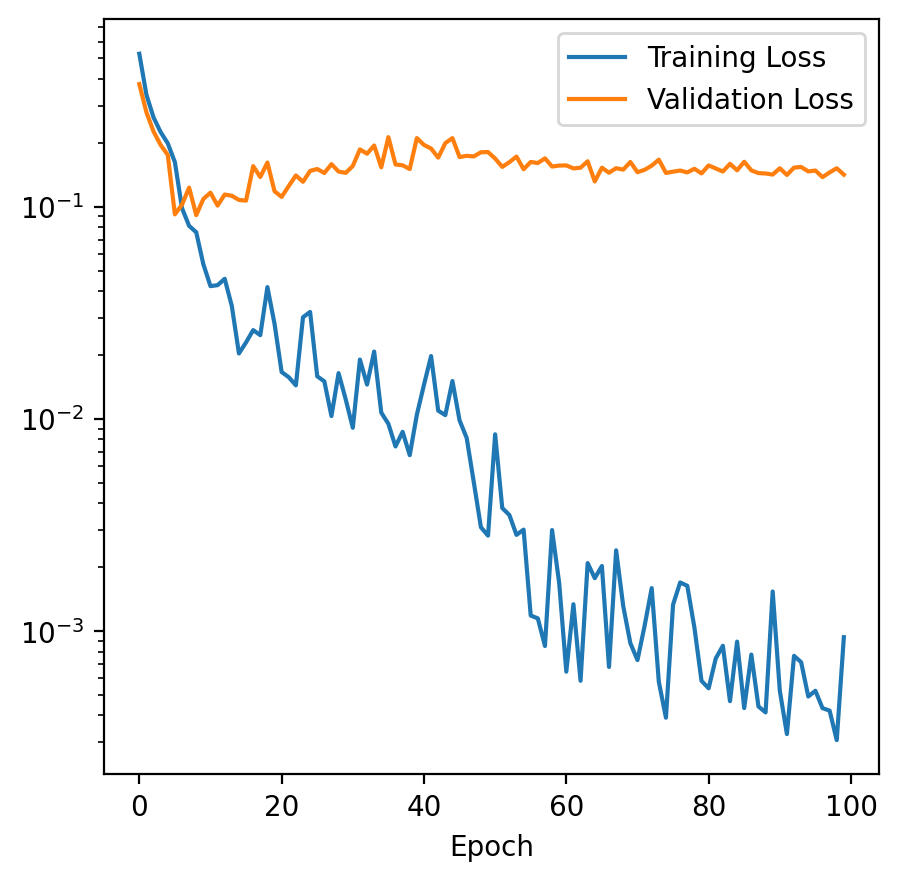

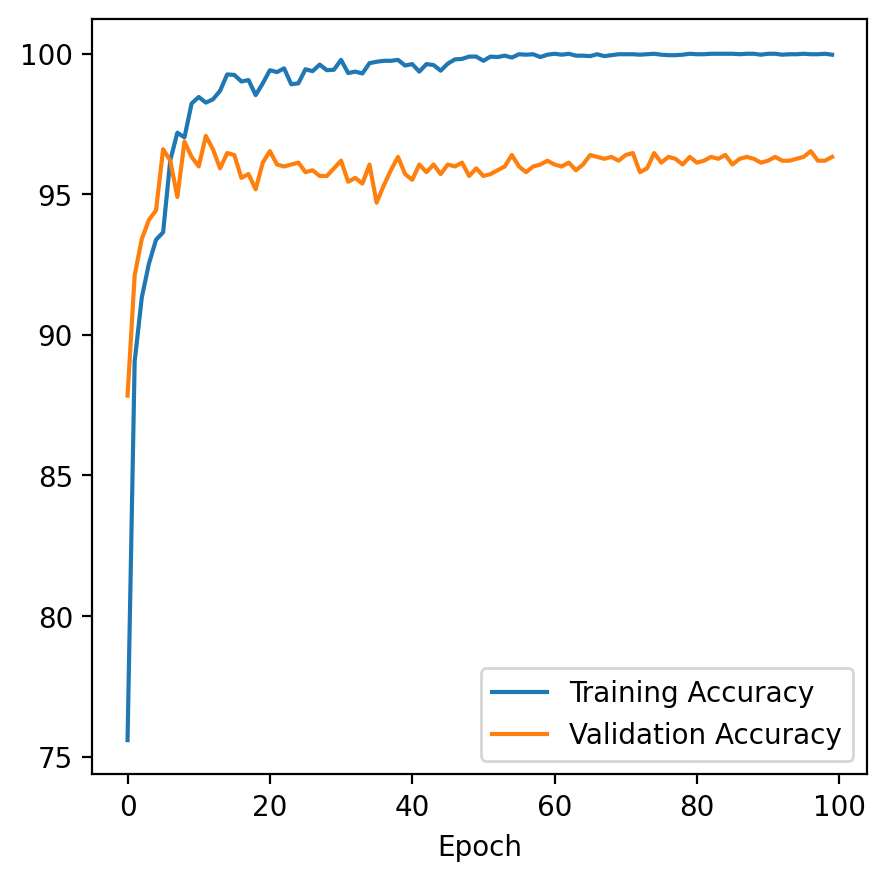

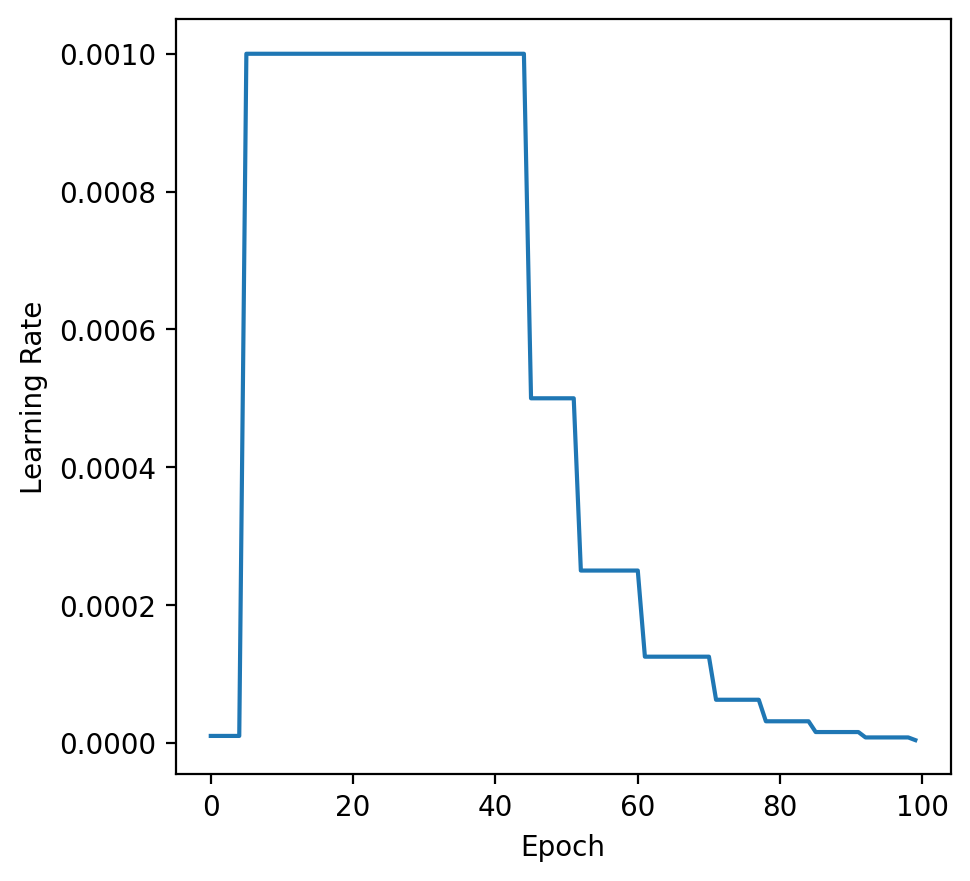

In [14]:
from matplotlib import pyplot as plt
my_dpi = 200
plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.semilogy(range(0,scratch_model['epoch']), scratch_model['losses_tr'],label='Training Loss')
plt.semilogy(range(0,scratch_model['epoch']), scratch_model['losses_val'],label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - Loss.png', dpi=200 * 10)
plt.show()

plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['accuracy_train'],label='Training Accuracy')
plt.plot(range(0,scratch_model['epoch']), scratch_model['accuracy_val'],label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - Accuracy.png', dpi=200 * 10)
plt.show()


plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['learning_rate'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - LR.png', dpi=200 * 10)
plt.show()

In [18]:
basedir = 'nets/ckpt_CAE_2d_classify_001/'
scratch_model = torch.load(basedir+'Classify_Trained_001_latest.pth.tar')
img_size = [80, 80, 80, 1]
num_clusters = 2
latent_channels = 512
model_name = 'CAE_2d_classify'
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)
model.to(device)
model.load_state_dict(scratch_model['best_model_wts'])
model.eval()
print(model)

CAE_2d_classify(
  (encoder2d): Sequential(
    (conv2d1_1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (relu2d1_1): ReLU()
    (bn2d1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d2_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (relu2d2_1): ReLU()
    (bn2d2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d3_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (relu2d3_1): ReLU()
    (bn2d3_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (relu2d4_1): ReLU()
  )
  (embedding2d): Linear(in_features=4096, out_features=512, bias=False)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, t